### Two Kinds of PAC

In earlier notebooks we calculated whether a signal contains PAC and extracted features. In this notebook we show that the selected channels contain two different kinds of PAC: 

1. True interactions between oscillators
2. PAC caused by the transformation of non-sinusoidal features of a signal

### Features

The features we extracted can be split up in three categories:

1. PAC values:    
                 Rho value & resampled Z-value 

2. PSD parameters extracted with FoooF:    
                 Aperiodic & periodic components  

3. Non-sinusoidal components extracted with ByCycle:   
                 Symmetry measures & peak voltage

### Some Settings and Imports 

In [1]:
# This magic command plots figures directly in the notebook
%matplotlib inline
# This sets a higher resolution for figures
%config InlineBackend.figure_format = 'retina'

import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


import mglearn

C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load Data and Create Variables out of the Data Structure

In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# Use Pickle to load data
load_data = open('clean_db_20s.pkl','rb')
clean_db = pickle.load(load_data)

# Extract variables 
subj_name   = clean_db['subj_name']
subj        = clean_db['subj']
ch          = clean_db['ch']
ep          = clean_db['ep']
locs        = clean_db['locs']
dat_name    = clean_db['dat_name']
data        = clean_db['data']
pac_rhos    = clean_db['pac_rhos']
resamp_zvals = clean_db['resamp_zvals']
resamp_pvals = clean_db['resamp_pvals']
psd_params  = clean_db['psd_params']
backgr_params = clean_db['backgr_params']
rd_sym      = clean_db['rd_sym']
pt_sym      = clean_db['pt_sym']
bursts      = clean_db['bursts']
period      = clean_db['period']
volt_amp    = clean_db['volt_amp']
fs          = clean_db['fs']

# For some variables, calculate the mean, median and/or STD
mean_rd_sym     = [np.mean(rd_sym[ii]) for ii in range(len(rd_sym))]
median_rd_sym   = [np.median(rd_sym[ii]) for ii in range(len(rd_sym))]
std_rd_sym      = [np.std(rd_sym[ii]) for ii in range(len(rd_sym))]

mean_pt_sym     = [np.mean(pt_sym[ii]) for ii in range(len(pt_sym))]
median_pt_sym   = [np.median(pt_sym[ii]) for ii in range(len(pt_sym))]
std_pt_sym      = [np.std(pt_sym[ii]) for ii in range(len(pt_sym))]

median_volt_amp = [np.median(volt_amp[ii]) for ii in range(len(volt_amp))]
median_period   = [np.median(period[ii]) for ii in range(len(period))]

# Split psd_params into the Central Frequency, Amplitude and BandWidth
psd_cf          = [psd_params[ii][0] for ii in range(len(psd_params))]
psd_amp         = [psd_params[ii][1] for ii in range(len(psd_params))]
psd_bw          = [psd_params[ii][2] for ii in range(len(psd_params))]

# Also split the background_params into seperate parameters
backgr_offset = [backgr_params[ii][0] for ii in range(len(backgr_params))]
backgr_knee   = [backgr_params[ii][1] for ii in range(len(backgr_params))]
backgr_exp  = [backgr_params[ii][2] for ii in range(len(backgr_params))]

clean_db.clear()

In [3]:
# put some features into dataframe for easier visualization
features_df = pd.DataFrame()
features_df['pac_rhos'] = pac_rhos 
features_df['resamp_zvals'] = resamp_zvals
features_df['median_rd_sym'] = median_rd_sym
features_df['median_pt_sym'] = median_pt_sym
features_df['psd_cf'] = psd_cf
features_df['psd_amp'] = psd_amp
features_df['psd_bw'] = psd_bw
features_df['backgr_exp'] = backgr_exp
features_df['backgr_offset'] = backgr_offset
features_df['backgr_knee'] = backgr_knee
features_df['median_volt_amp'] = median_volt_amp

# 1. Investigate Features Using Correlation Matrix

First, we inspect the features and see which correlate. If they do, either remove some features, or merge features, otherwise they will affect the results

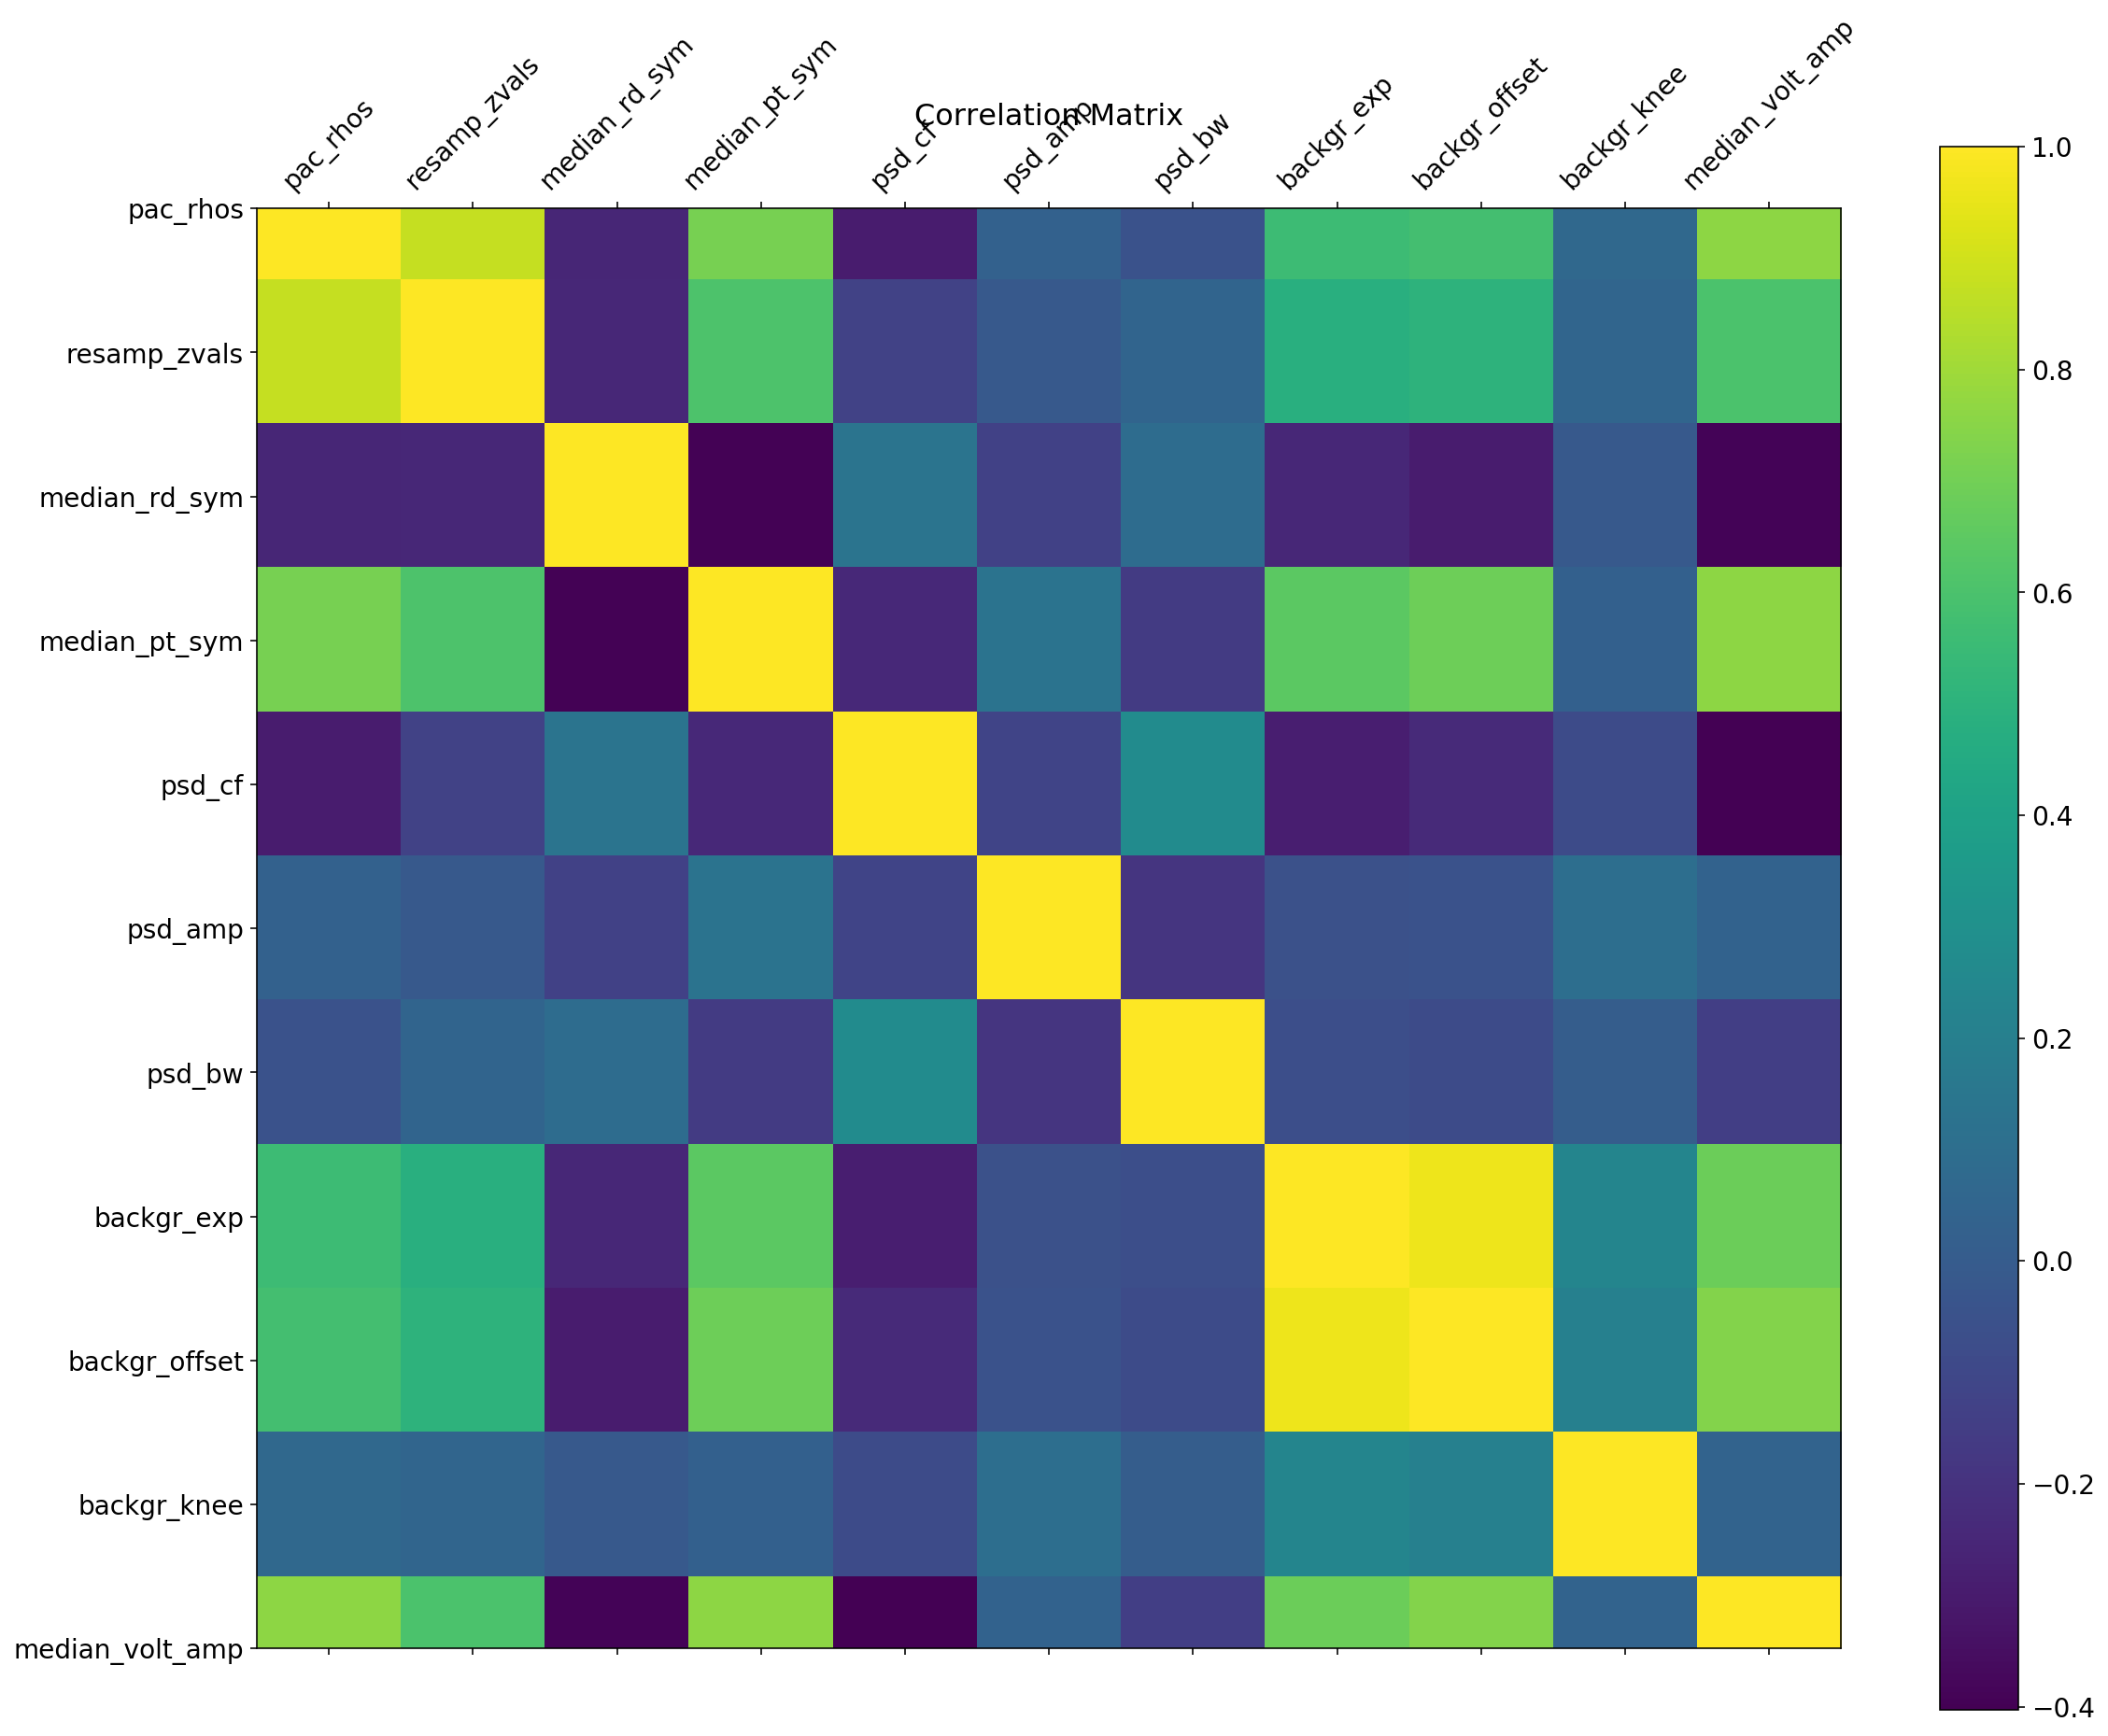

In [4]:
f = plt.figure(figsize=(19, 15))
plt.matshow(features_df.corr(), fignum=f.number)
plt.xticks(range(features_df.shape[1]), features_df.columns, fontsize=14, rotation=45)
plt.yticks(range(features_df.shape[1]), features_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

 <div class="alert alert-danger">
Both measures of the PAC value and two of the background parameters correlate too much with each other
</div>

### Making A Few Adjustments After Feature Inspection


1. Drop 'Knee' of the FOOOF background parameters (homogeneous data)

In [5]:
# drop knee
features_df = features_df.drop(columns='backgr_knee')

2. Log10 the PSD Bandwidth

In [6]:
psd_bw_log10 = np.log10(psd_bw)

# Log transfer psd_bw
features_df['psd_bw_log'] = np.log10(features_df['psd_bw'])
# drop old psd_bw for clean df
features_df = features_df.drop(columns='psd_bw')


### Change Shape for SKlearn

In [7]:
# change to right shape for sklearn
pac_rhos = np.reshape(pac_rhos, [len(pac_rhos), 1])
resamp_zvals = np.reshape(resamp_zvals, [len(resamp_zvals), 1])
median_rd_sym  = np.reshape(median_rd_sym, [len(median_rd_sym), 1])
median_pt_sym = np.reshape(median_pt_sym, [len(median_pt_sym), 1])
psd_cf = np.reshape(psd_cf, [len(psd_cf), 1])
psd_amp = np.reshape(psd_amp, [len(psd_amp), 1])
backgr_exp = np.reshape(backgr_exp, [len(backgr_exp), 1])
backgr_offset = np.reshape(backgr_offset, [len(backgr_offset), 1])
median_volt_amp = np.reshape(median_volt_amp, [len(median_volt_amp), 1])
psd_bw_log10 = np.reshape(psd_bw_log10, [len(psd_bw_log10), 1])

3. Create 1 feature out of pac_rhos + resamp_zvals, because they are almost same measure and highly correlate

In [8]:
# first scale both data and then add them
scaler = StandardScaler()
pac_values = scaler.fit_transform(pac_rhos) + scaler.fit_transform(resamp_zvals)

# write pac_values to dataframe
features_df['pac_values'] = pac_values

In [9]:
# first scale both data and then add them
scaler = StandardScaler()
pac_values = scaler.fit_transform(pac_rhos) + scaler.fit_transform(resamp_zvals)

4. Create 1 feature out of backgr_exp and offset, because they highly correlate


In [10]:
# first scale both data and then add them
scaler = StandardScaler()
aperiodic_param = scaler.fit_transform(backgr_exp) + scaler.fit_transform(backgr_offset)

In [11]:
# Also change new variables to prefered shape for SKlearn
aperiodic_param = np.reshape(aperiodic_param, [len(aperiodic_param), 1])
pac_values = np.reshape(pac_values, [len(pac_values), 1])

In [12]:
# Stack all features to create one 'X_hat'
pac_features = np.hstack((pac_values, median_rd_sym, median_pt_sym, median_volt_amp, \
                           aperiodic_param, psd_cf, psd_amp, psd_bw_log10))

In [13]:
# Last, scale all data 
scaler = StandardScaler()
scaler.fit(pac_features)
X_scaled = scaler.transform(pac_features)

# 2. Clustering with K-Means Analysis + Principal Component Analysis

Because the true and spurious PAC both have different origins (true interactions versus non-sinusoidal features), we expect these types of PAC differ on at least some of the features. Therefore, we use the unsupervised K-Means machine learning method. For visualization purposes we do a Principal Component Analysis for dimensionality reduction so we can visualize the clusters on two dimensions. 

In [14]:
# Use K-Means to cluster into two groups
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled);

In [15]:
# Use PCA to create two components
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [16]:
# Create list with feature names for visualization 
feature_list = ['PAC values', 'RD Sym', 'PT Sym', 'Volt Amp', \
                'PSD Aperiodic', 'PSD CF', 'PSD Amp', 'PSD BW']

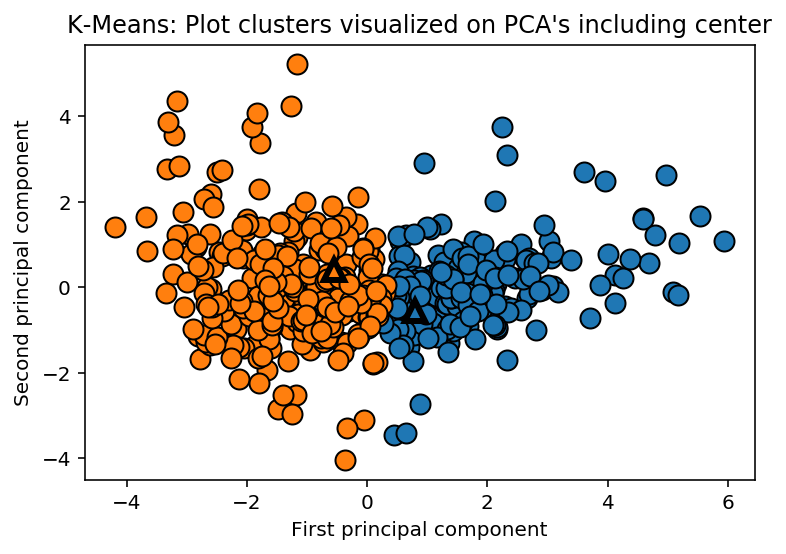

In [17]:
# visualize on PCA  
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:,1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1], markers='^', markeredgewidth=3)
plt.title('K-Means: Plot clusters visualized on PCA\'s including center')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

features_df['Clusters'] = kmeans.labels_
cluster_label = kmeans.labels_

 <div class="alert alert-success">
The groups are almost fully clustered based on features of the first component, suggesting this component is much stronger as the second component. What are these components?
</div>





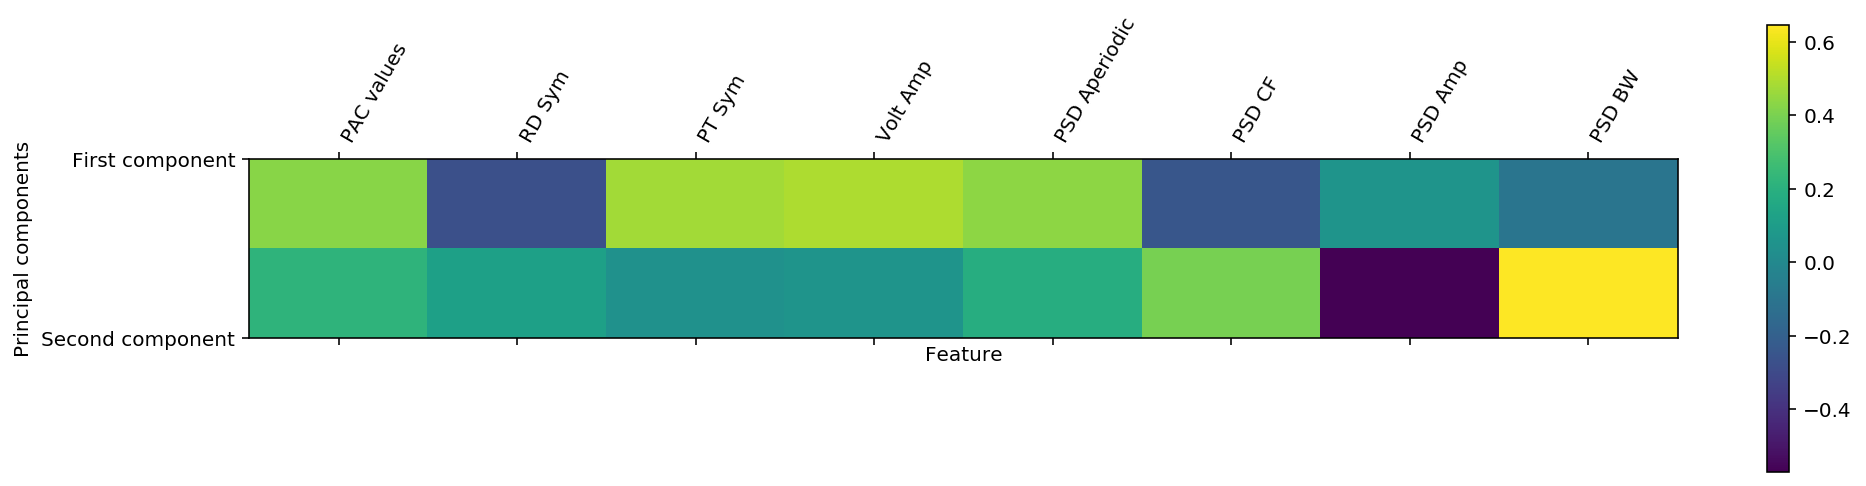

In [18]:
# Which features drive both components?
plt.matshow(pca.components_, cmap='viridis');
plt.yticks([0, 1], ["First component", "Second component"]);
plt.colorbar();
plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left');
plt.xlabel("Feature");
plt.ylabel("Principal components");

 <div class="alert alert-success">
Interestingly, the first component consists pac_values, symmetry measures, and aperiodic parameters, while the second parameter consists mostly of periodic (PSD) measures. 
</div>

# 3. Linear Regression Models 

If these two clusters truly have different origins, but have likeawise PAC values (which is the average of the Rho value and the resampled Z value), these PAC values should arise because of different reasons. To test this, we apply linear regression models on both clusters to see whether the PAC value is predicted by different features for both clusters 

In [19]:
# Set variables for preallocation
features_cluster0 = np.zeros([(cluster_label==0).sum(),len(X_scaled[0])])
features_cluster1 = np.zeros([(cluster_label==1).sum(),len(X_scaled[0])])

# iterate over features and select those values that belong to a cluster
for ii in range(len(X_scaled[0])):
    features_cluster0[:,ii] = [X_scaled[jj,ii] for jj in range(len(X_scaled)) if cluster_label[jj] == 0]
    features_cluster1[:,ii] = [X_scaled[jj,ii] for jj in range(len(X_scaled)) if cluster_label[jj] == 1]
    
# get X and Y_hat (splits features into pac_value and other features)
X_cluster0 = features_cluster0[:,1:]
X_cluster1 = features_cluster1[:,1:]

Y_cluster0 = features_cluster0[:,0]
Y_cluster1 = features_cluster1[:,0]

In [20]:
# regression fit
reg_cluster0 = linear_model.LinearRegression().fit(X_cluster0, Y_cluster0)
reg_cluster1 = linear_model.LinearRegression().fit(X_cluster1, Y_cluster1)

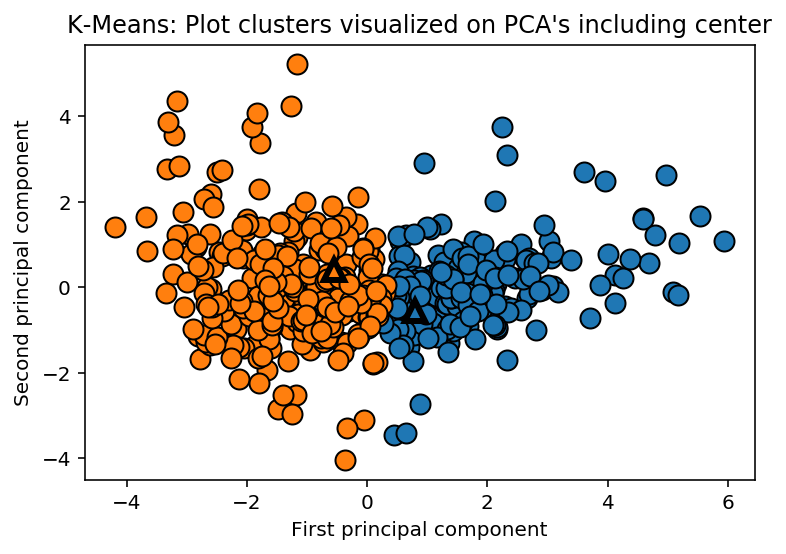

In [21]:
# Show which clustering is used for the linear models
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1], markers='^', markeredgewidth=3)
plt.title('K-Means: Plot clusters visualized on PCA\'s including center')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

features_df['Clusters'] = kmeans.labels_
cluster_label = kmeans.labels_

In [22]:
# Create list with feature names for visualization 
feature_list = ['pac_values', 'median_rd_sym', 'median_pt_sym', 'median_volt_amp', \
                'aperiodic_param', 'psd_cf', 'psd_amp', 'psd_bw_log10']

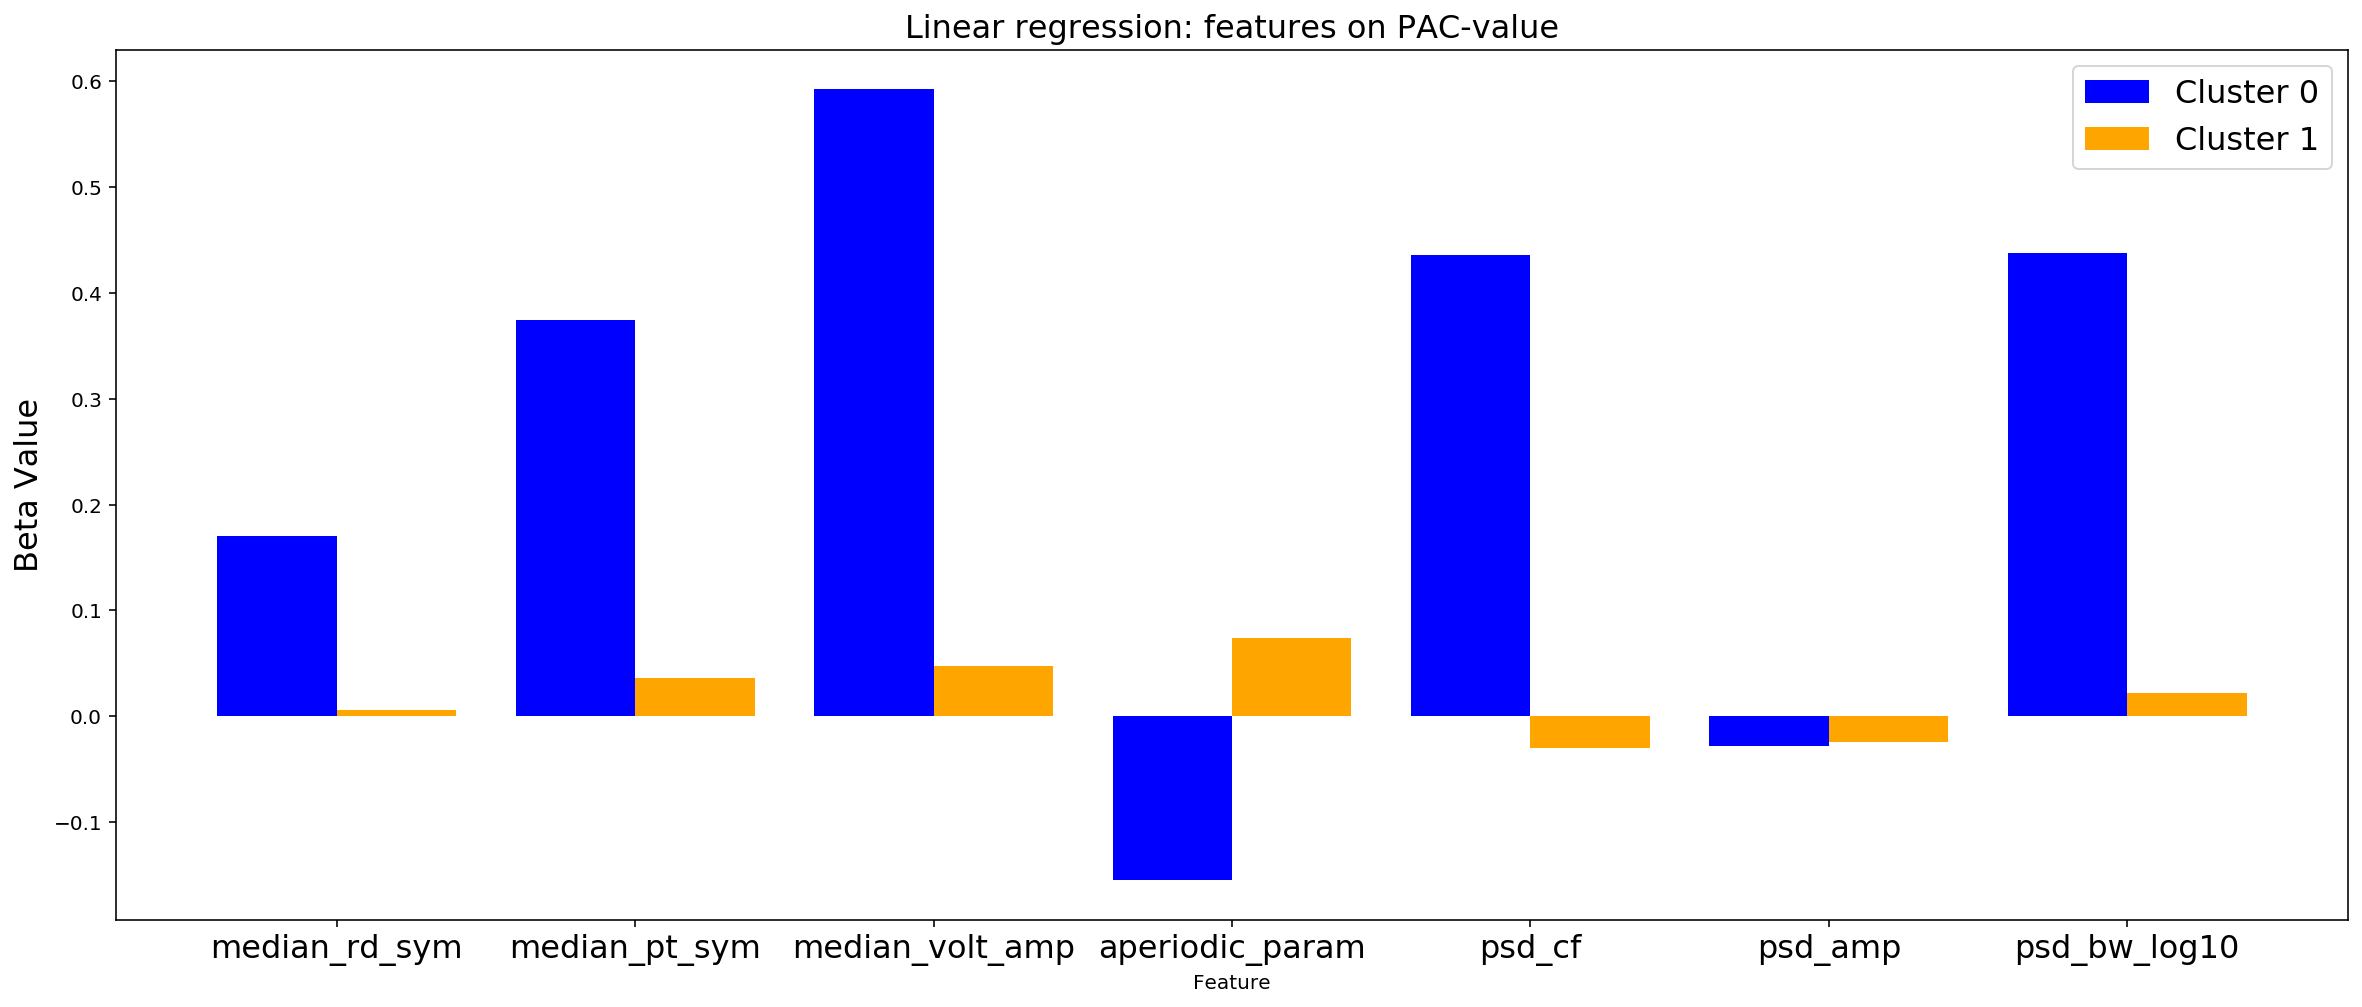

In [23]:
# Plot Beta values for the prediction of the PAC value for cluster 0, cluster 1, and the difference
plt.figure(figsize=(20,8))
index = np.arange(7)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, reg_cluster0.coef_, bar_width,
color='blue',
label='Cluster 0')

rects2 = plt.bar(index + bar_width, reg_cluster1.coef_, bar_width,
color='orange',
label='Cluster 1')


plt.xlabel('Feature')
plt.ylabel('Beta Value',fontsize=16)
plt.title('Linear regression: features on PAC-value',fontsize=16)
plt.xticks(index + (bar_width/2), feature_list[1:8],fontsize=16)
plt.legend(fontsize=16)

 <div class="alert alert-success">
We find huge differences between the two clusters. Where one cluster is strongly affected by multiple PSD components and non-sinusoidal characteristics, the other cluster is hardly affected by these features. This suggests the K-means clustering did a good job seperating the true oscillations (which are expected NOT to be affected by features such as symmetry and voltage amplitude), and spurious PAC (which are expected to be affected by those features). 

</div>

# 4. Compare to Non-Significant Channels (that have true oscillation)

So far, we have only looked at the signal that show significant PAC after statistical resampling. But what do the features of signal that DO have a true oscillation (with a CF under 15 Hz, and with an peak Amp between 0.2 and 1.5), but DO NOT have significant PAC after resampling. 

### Preprocessing for No PAC data

In [24]:
# change dir 
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# use pickle to load data
load_data = open('clean_db_nopac_20s.pkl','rb')
clean_db_nopac = pickle.load(load_data)

# Extract variables from datastruct
subj_name   = clean_db_nopac['subj_name']
subj        = clean_db_nopac['subj']
ch          = clean_db_nopac['ch']
locs        = clean_db_nopac['locs']
dat_name    = clean_db_nopac['dat_name']
data        = clean_db_nopac['data']
pac_rhos_nopac    = clean_db_nopac['pac_rhos']
resamp_zvals_nopac = clean_db_nopac['resamp_zvals']
resamp_pvals_nopac = clean_db_nopac['resamp_pvals']
psd_params_nopac  = clean_db_nopac['psd_params']
backgr_params_nopac = clean_db_nopac['backgr_params']
rd_sym_nopac      = clean_db_nopac['rd_sym']
pt_sym_nopac      = clean_db_nopac['pt_sym']
bursts_nopac      = clean_db_nopac['bursts']
period_nopac      = clean_db_nopac['period']
volt_amp_nopac    = clean_db_nopac['volt_amp']
fs          = clean_db_nopac['fs']

# For some variables, calculate the mean, median and/or STD 
mean_rd_sym_nopac     = [np.mean(rd_sym_nopac[ii]) for ii in range(len(rd_sym_nopac))]
median_rd_sym_nopac   = [np.median(rd_sym_nopac[ii]) for ii in range(len(rd_sym_nopac))]
std_rd_sym_nopac      = [np.std(rd_sym_nopac[ii]) for ii in range(len(rd_sym_nopac))]

mean_pt_sym_nopac     = [np.mean(pt_sym_nopac[ii]) for ii in range(len(pt_sym_nopac))]
median_pt_sym_nopac   = [np.median(pt_sym_nopac[ii]) for ii in range(len(pt_sym_nopac))]
std_pt_sym_nopac      = [np.std(pt_sym_nopac[ii]) for ii in range(len(pt_sym_nopac))]

median_volt_amp_nopac = [np.median(volt_amp_nopac[ii]) for ii in range(len(volt_amp_nopac))]
median_period_nopac   = [np.median(period_nopac[ii]) for ii in range(len(period_nopac))]

# Split psd_params into the Central Frequency, Amplitude and BandWidth
psd_cf_nopac          = [psd_params_nopac[ii][0] for ii in range(len(psd_params_nopac))]
psd_amp_nopac         = [psd_params_nopac[ii][1] for ii in range(len(psd_params_nopac))]
psd_bw_nopac          = [psd_params_nopac[ii][2] for ii in range(len(psd_params_nopac))]

# Also split background parameters
backgr_offset_nopac = [backgr_params_nopac[ii][0] for ii in range(len(backgr_params_nopac))]
backgr_knee_nopac   = [backgr_params_nopac[ii][1] for ii in range(len(backgr_params_nopac))]
backgr_exp_nopac  = [backgr_params_nopac[ii][2] for ii in range(len(backgr_params_nopac))]

# close datastructure
clean_db_nopac.clear()

Also create a dataframe for the No PAC data for visualization purposes

In [25]:
features_df_nopac = pd.DataFrame()
features_df_nopac['pac_rhos_nopac'] = pac_rhos_nopac 
features_df_nopac['resamp_zvals_nopac'] = resamp_zvals_nopac
features_df_nopac['median_rd_sym_nopac'] = median_rd_sym_nopac
features_df_nopac['median_pt_sym_nopac'] = median_pt_sym_nopac
features_df_nopac['psd_cf_nopac'] = psd_cf_nopac
features_df_nopac['psd_amp_nopac'] = psd_amp_nopac
features_df_nopac['psd_bw_nopac'] = psd_bw_nopac
features_df_nopac['backgr_exp_nopac'] = backgr_exp_nopac
features_df_nopac['backgr_offset_nopac'] = backgr_offset_nopac
features_df_nopac['backgr_knee_nopac'] = backgr_knee_nopac
features_df_nopac['median_volt_amp_nopac'] = median_volt_amp_nopac

# get rid of knee, just like in PAC data
features_df_nopac = features_df_nopac.drop(columns='backgr_knee_nopac')

# Log transfer psd_bw_nopac (just like in PAC data)
features_df_nopac['psd_bw_nopac_log'] = np.log10(features_df_nopac['psd_bw_nopac'])
# drop old psd_bw_nopac for clean df
features_df_nopac = features_df_nopac.drop(columns='psd_bw_nopac')

Get data in the right SK learn format and Standard Scale data

In [26]:
# first, logtransform bandwidth
psd_bw_nopac_log10 = np.log10(psd_bw_nopac)

# change to right shape for sklearn
pac_rhos_nopac = np.reshape(pac_rhos_nopac, [len(pac_rhos_nopac), 1])
resamp_zvals_nopac = np.reshape(resamp_zvals_nopac, [len(resamp_zvals_nopac), 1])
median_rd_sym_nopac  = np.reshape(median_rd_sym_nopac, [len(median_rd_sym_nopac), 1])
median_pt_sym_nopac = np.reshape(median_pt_sym_nopac, [len(median_pt_sym_nopac), 1])
psd_cf_nopac = np.reshape(psd_cf_nopac, [len(psd_cf_nopac), 1])
psd_amp_nopac = np.reshape(psd_amp_nopac, [len(psd_amp_nopac), 1])
backgr_exp_nopac = np.reshape(backgr_exp_nopac, [len(backgr_exp_nopac), 1])
backgr_offset_nopac = np.reshape(backgr_offset_nopac, [len(backgr_offset_nopac), 1])
median_volt_amp_nopac = np.reshape(median_volt_amp_nopac, [len(median_volt_amp_nopac), 1])
psd_bw_nopac_log10 = np.reshape(psd_bw_nopac_log10, [len(psd_bw_nopac_log10), 1])

# and create 1 feature out of pac_rhos_nopac + resamp_zvals_nopac
scaler = StandardScaler()
pac_values_nopac = scaler.fit_transform(pac_rhos_nopac) + scaler.fit_transform(resamp_zvals_nopac)

# and create 1 feature out of backgr_exp_nopac and offset
scaler = StandardScaler()
aperiodic_param_nopac = scaler.fit_transform(backgr_exp_nopac) + scaler.fit_transform(backgr_offset_nopac)

# change to right shape for sklearn 
aperiodic_param_nopac = np.reshape(aperiodic_param_nopac, [len(aperiodic_param_nopac), 1])
pac_values_nopac = np.reshape(pac_values_nopac, [len(pac_values_nopac), 1])

pac_features_nopac = np.hstack((pac_values_nopac, median_rd_sym_nopac, median_pt_sym_nopac, median_volt_amp_nopac, \
                           aperiodic_param_nopac, psd_cf_nopac, psd_amp_nopac, psd_bw_nopac_log10))

# scale data
scaler = StandardScaler()
scaler.fit(pac_features_nopac)
X_scaled_nopac = scaler.transform(pac_features_nopac)

# 4.1 Comparing regression model of No PAC with PAC clusters

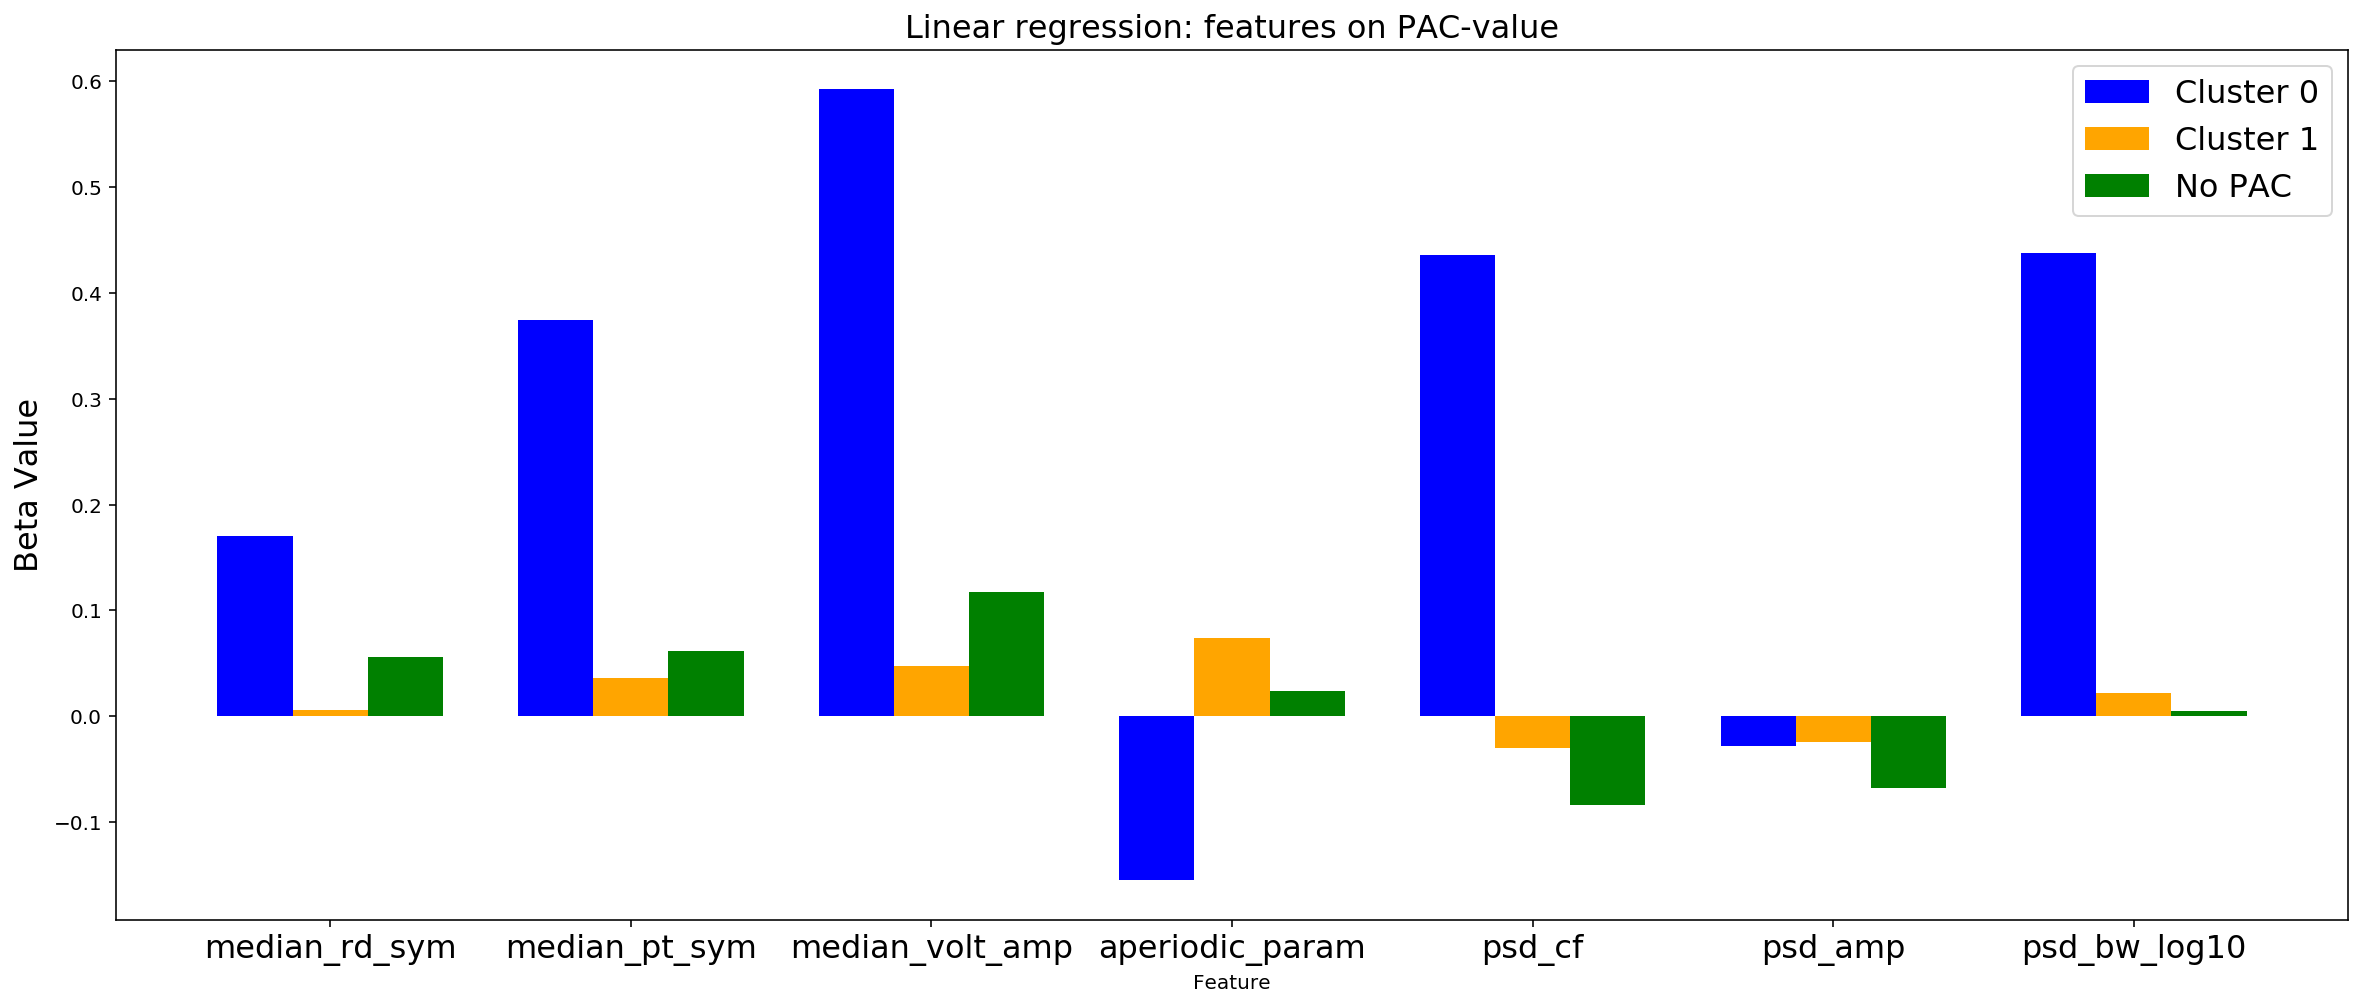

In [27]:
# regression fit
reg_cluster0 = linear_model.LinearRegression().fit(X_cluster0, Y_cluster0)
reg_cluster1 = linear_model.LinearRegression().fit(X_cluster1, Y_cluster1)

# get X_scaled_nopac
X_nopac = X_scaled_nopac[:,1:]
Y_nopac = X_scaled_nopac[:,0]

# linear regression
reg_nopac = linear_model.LinearRegression().fit(X_nopac, Y_nopac)

# create plot
#fig, ax = plt.subplots()
plt.figure(figsize=(20,8))
index = np.arange(7)
bar_width = 0.25

rects1 = plt.bar(index, reg_cluster0.coef_, bar_width,
color='blue',
label='Cluster 0')

rects2 = plt.bar(index + bar_width, reg_cluster1.coef_, bar_width,
color='orange',
label='Cluster 1')

rects3 = plt.bar(index + (bar_width * 2), reg_nopac.coef_, bar_width,
color='green',
label='No PAC')

plt.xlabel('Feature')
plt.ylabel('Beta Value',fontsize=16)
plt.title('Linear regression: features on PAC-value',fontsize=16)
plt.xticks(index + bar_width, feature_list[1:8],fontsize=16)
plt.legend(fontsize=16)

 <div class="alert alert-success">
When we compare the beta-coefficients of the No PAC (but true oscillation) with the two clusters, we see that the No PAC coefficients in predicting the PAC value looks quiet the same as the cluster which is though to be the 'true PAC' group. Both the true PAC group and No PAC group are little affected by PSD and non-sinusoidal features. 
<br><br>
This further supports the claim that the other PAC cluster clearly is different from all other data that have a true oscillator, and holds characteristics, such as higher assymetry and higher voltage, that cause spurious PAC.
<br><br>
In most cases, the No PAC is very similar to the true PAC cluster, but slightly leaning towards the spurious PAC clusters. This makes sense, because where in the PAC clusters are differentiated based on the PSD and non-sinusoidal features, this is not the case in the No PAC group. So in the No PAC group, to some extent, this characteristics are present (but not so much that they cause significant spurious PAC). 


</div>

# 5. Differences of the Three Groups in Feature Distribution

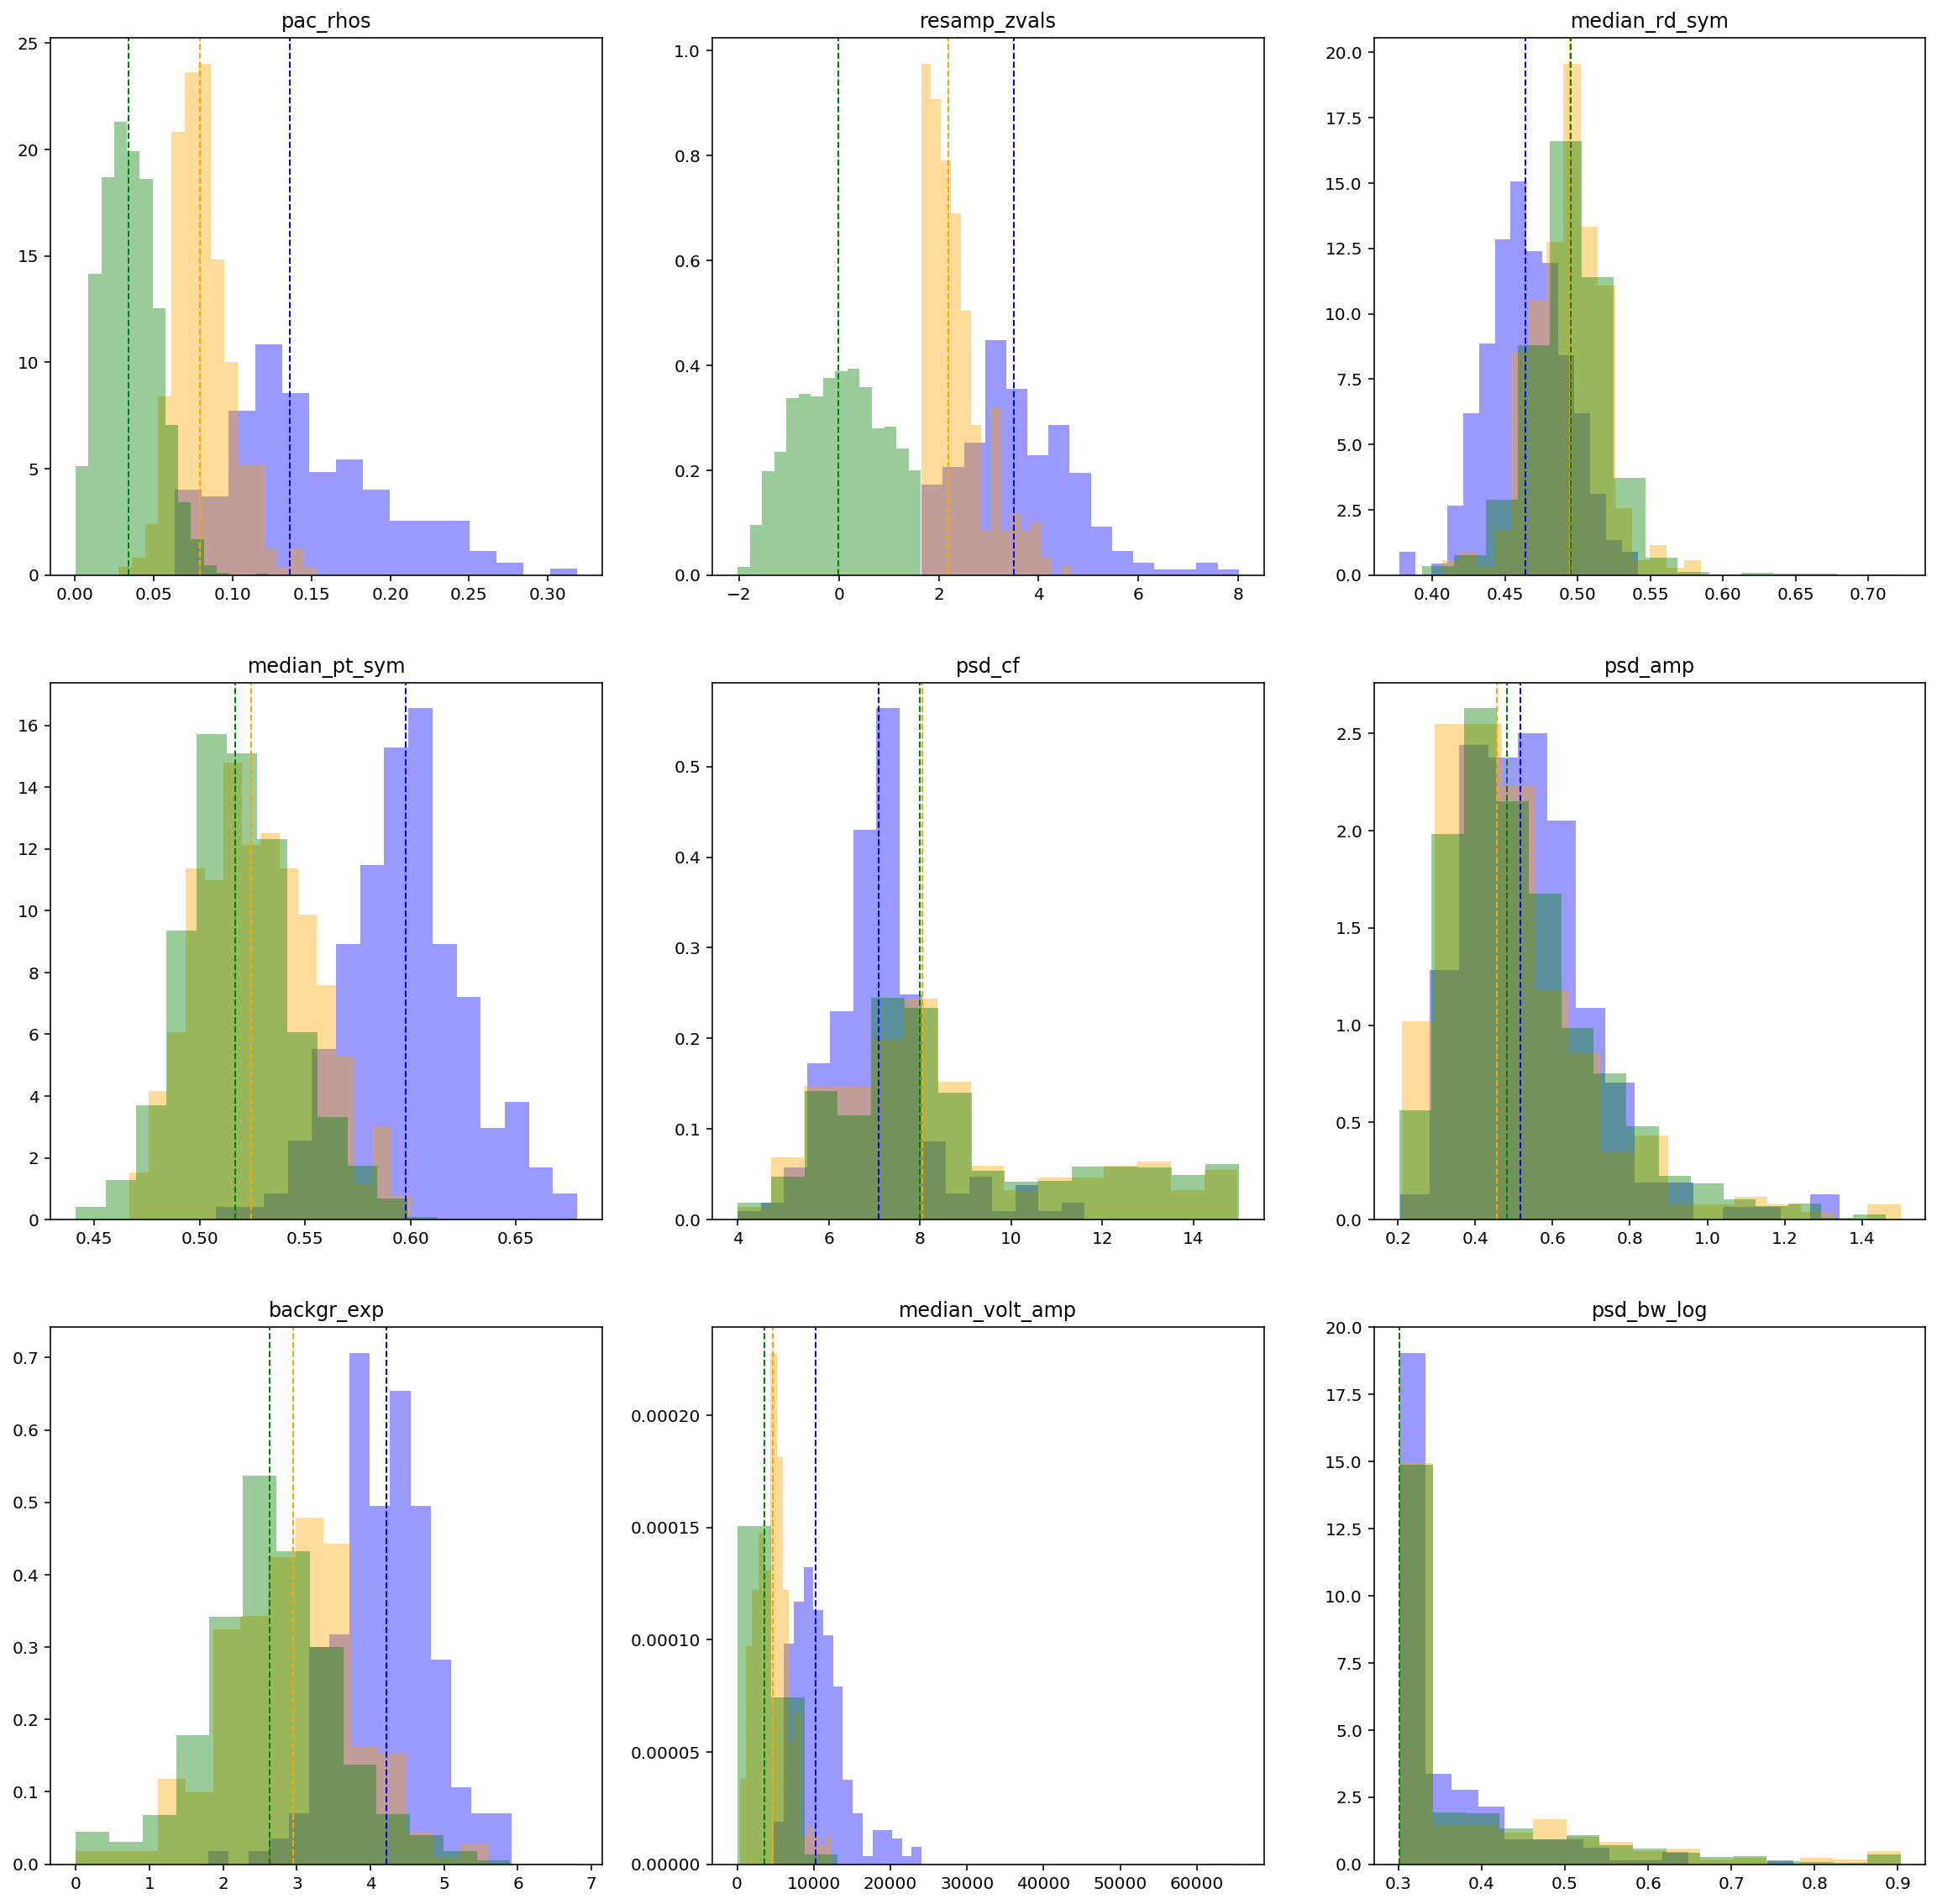

In [28]:
# manually set which columns you want to plot
plot_list = [0,1,2,3,4,5,6,8,9]


kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=15)

plt.figure(figsize=(20,20))
for ii in range(len(plot_list)): 
        
    jj = plot_list[ii]
    # subplots 3x3
    plt.subplot(3,3,ii+1)
    #xticks([]), yticks([])
    
    plt.hist(features_df[features_df['Clusters']==0][features_df.columns[jj]], color='blue', **kwargs)
    plt.hist(features_df[features_df['Clusters']==1][features_df.columns[jj]], color='orange',**kwargs)
    plt.hist(features_df_nopac.iloc[:,jj], color='green', **kwargs)

    plt.title(features_df.columns[jj])
    
    plt.axvline(np.median(features_df[features_df['Clusters']==0][features_df.columns[jj]]), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(features_df[features_df['Clusters']==1][features_df.columns[jj]]), color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(features_df_nopac.iloc[:,jj]), color='green', linestyle='dashed', linewidth=1)

    

<div class="alert alert-success">
Histograms of the distributions of the groups confirm earlier findings. The distrubtion of the No PAC and the true PAC cluster are quiet the same. On some features, the spurious PAC clusters show very different distributions. These include: 
<br><br>
    1. Higher PAC Values
<br>
    2. More Assymetry
<br>
    3. Higher Voltage Amplitude
<br>
    4. Higher Aperiodic Component (backgr_exp)
<br><br>
The PAC value is the outcome value, symmetry measures and higher voltage are known to cause spurious PAC, but the most interesting finding is the difference in the Aperiodic component, which distinguishes between the two PAC clusters. Also, this parameter, interestingly, shows (as only feature) a negative beta coefficient in the spurious PAC cluster, while it is the biggest, positive, bèta coefficient in the true PAC group. 


</div>

In [29]:
# save processed dataframes with clusters for future use
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')


# write pac_values to dataframe
features_df['pac_values'] = pac_values
features_df_nopac['pac_values_nopac'] = pac_values_nopac

# save as csv
features_df.to_csv('features_df.csv', sep=',', index=False)
features_df_nopac.to_csv('features_df_nopac.csv', sep=',', index=False)